In [1]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import time
from math import ceil
import yaml, laspy
import lithops
import pandas as pd
import numpy as np
import neilpy
from lithops.storage.cloud_proxy import open, os as os_cl
from lithops import ServerlessExecutor
from lidarpartitioner import lidarutils, utils
from lidarpartitioner.las_partitioner import Partitioner
from lidarpartitioner.lidarutils import *
import lidarpartitioner
from lithops.worker.utils import get_memory_usage
from sklearn.neighbors import KDTree

In [3]:
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

datet = dt_string.replace(":", "_").replace(" ","_").replace("/","_")

In [4]:
def partition_file(fname, out_dir, num_points, sufix, buffer):
    divider = Partitioner(fname, sufix)
    m_threshold = num_points
    divider.make_partition(out_dir, capacity=m_threshold, buffer=buffer)

In [5]:
def smrf_filter(id, file, smrf_reults, buffer, call_time):
    
    st_map_process = time.time()
    Allprocessing_time = dict()
    Allprocessing_time['Object_name'] = file.split('/')[-1]
    Allprocessing_time['Map_ID'] = id
    Allprocessing_time['Buffer'] = buffer
    Allprocessing_time['Time_Mapstart'] = round(st_map_process - call_time, 3)
    print("ID of the function: %s" % str(id))
    
    
    # read data stream
    st_read = time.time()
    with open(file, 'rb') as f:
        inF = laspy.read(f)
    point_cloud = np.vstack((inF.x, inF.y, inF.z, inF.withheld)).T
    df = pd.DataFrame(data=point_cloud, columns=['X', 'Y', 'Z', 'Withheld'])
    print(df.head(10))
    download_data = time.time() - st_read
    Allprocessing_time['Downloading_Time'] = round(download_data, 3)  
       
    
    # Run SMRF
    st_filter = time.time()
    cellsize = 2
    windows = 12
    slope_threshold = .15 
    elevation_threshold = 0.30
    elevation_scaler = 0.95
    
        
    
    try:
        
        Zsmrf, Tsmrf, obj_cells, obj_points = neilpy.smrf(df.X,df.Y,df.Z,cellsize,windows,slope_threshold,
                                                          elevation_threshold,elevation_scaler)
        
        filtering_time = time.time() - st_filter
            
        # Save the ground points 
        st_wres = time.time()
        fname, data = lidarutils.writer_lasfile(inF, obj_points, file, reduce_stream = True)
        en_wres = time.time() - st_wres
    except Exception as e:
        print('Failed!!. Reason: %s' %(e))
        
    Allprocessing_time['Filtering_time'] = round(filtering_time, 3)
    Allprocessing_time['Save_points'] = round(en_wres, 3)
    Allprocessing_time['Maping_time'] = round(time.time() - st_map_process, 3)
    Allprocessing_time['sendResult_time'] = time.time()
    
    return Allprocessing_time, data

def merg_res(results):
    
    st_reducer = time.time()
    pr_time = dict()
    merging = dict()
    Filtering_time, RWData_time, Maping_time, sendResult_time  = [], [], [], []
    Save_points, PeriodTime_Mapstart = [], []
    num_part = len(results)
    buffer = results[0][0]['Buffer']
    print(num_part)
    
    res_mapdata = []
    for res in results:
        obj = dict()
        RWData_time.append(res[0]['Downloading_Time'])
        Filtering_time.append(res[0]['Filtering_time'])
        Save_points.append(res[0]['Save_points'])
        Maping_time.append(res[0]['Maping_time'])
        PeriodTime_Mapstart.append(res[0]['Time_Mapstart'])
        sendResult_time.append(st_reducer - res[0]['sendResult_time'])
        obj['Object_name'] = res[0]['Object_name']
        obj['data_stream'] = res[1]
        res_mapdata.append(obj)
    del results
    
    # Start merging all the results
    st_merg = time.time()
    m_res = merg_files(res_mapdata, num_part, buffer)
    
    merging_time = time.time() - st_merg
    merging['Merging_time'] = merging_time
    
    pr_time['Funcs_numbers'] = num_part
    pr_time['File_name'] = m_res['File_name']
    pr_time['Points_number'] = m_res['Points_number']
    pr_time['Time_Mapstart'] = min(PeriodTime_Mapstart)
    pr_time['Time_Redstart'] = round(min(sendResult_time), 3)
    pr_time['Downloading_Time'] = max(RWData_time)
    pr_time['Filtering_time'] = max(Filtering_time)
    pr_time['Save_points'] = max(Save_points)
    pr_time['Maping_time'] = max(Maping_time)
    pr_time['Saving_data_time'] = m_res['Saving_data_time']
    pr_time['Merging_files_time'] = m_res['Merging_files_time']
    pr_time['Merged_uploading_time'] = m_res['Merged_uploading_time']
    pr_time['Merging_process'] = m_res['Merging_process']
    pr_time['Reduction_time'] = round(time.time() - st_reducer, 3)
    
    return pr_time

In [6]:
%%time
processing_time = []
data_folder = 'data'
chip_folder = 'chipres'
res_map_folder = 'smrf_reults'
res_red_folder = 'merged_files'
fname = data_folder + '/' + "Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4556-ORT-CLA-COL.las"
#"Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4556-ORT-CLA-COL.las" "lasfile.las"
# "Coloreado (RGB) 2016 - PNOA-2016-CAT-352-4554-ORT-CLA-COL.las"
# "Coloreado (RGB) 2016 - PNOA-2016-CAT-338-4556-ORT-CLA-COL.las"
folders = [chip_folder, res_map_folder]

for i in range(9):
    
    
    if i > 0:
        
        # Start partitioning
        # Clean folder in bucket if exists, if not create it
        [lidarutils.clean_folder(folder) for folder in folders]
    
        # Set variables and start partitioning
        partitions = 2**i
        buffer = 60
        num_points = ceil(5492898/partitions) #5492898 3791954 1373224 343306
        # print(num_points)
        
        partition_args = [(fname, chip_folder, num_points, i, buffer) for i in range(1)]
        st_split = time.time()
        with ServerlessExecutor(runtime_memory=3072) as exec: #runtime_memory=3072
            exec.map(partition_file, partition_args)
            exec.get_result()
        end_split = time.time() - st_split
        print(f'Total partition time: {end_split} s')
    
    # Processing files resulting from the partition stage 
    st_processing = time.time()
    if i == 0:
        map_runtime_memory = 2048
    elif i > 4:
        map_runtime_memory = 512
    else:
        map_runtime_memory = 1024
        
    files = os_cl.listdir(chip_folder)
    process_args = [(chip_folder + '/' + file, res_map_folder, buffer, st_processing) for file in files] if i > 0 \
                    else [(fname, res_map_folder, 0, st_processing)]
    # print(process_args)
    with ServerlessExecutor(runtime="ammarokran/new-smrf-conda36:1.0.6") as exec:
        exec.map_reduce(smrf_filter, process_args, merg_res, map_runtime_memory=map_runtime_memory,
                        reduce_runtime_memory=4096, include_modules=['lidarutils', 'lidarpartitioner', 'utils'])
        st_get = time.time()
        res = exec.get_result()
        end_get = time.time() - st_get
        # fexec.clean()
    end_processing = time.time() - st_processing
    res['GettingResult_time'] = round(end_get, 3)
    res['Processing_time'] = round(end_processing, 3)
    processing_time.append(res)
    print(f'Total processing time: {end_processing} s')

2021-11-03 20:57:30,244 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 20:57:30,311 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 20:57:30,314 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 20:57:30,316 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-0
2021-11-03 20:57:30,317 [INFO] lithops.invokers -- ExecutorID 850f58-0 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 2048MB 
2021-11-03 20:57:30,408 [INFO] lithops.job.job -- ExecutorID 850f58-0 | JobID M000 - Uploading function and data - Total: 49.8KiB
2021-11-03 20:57:32,097 [INFO] lithops.invokers -- ExecutorID 850f58-0 | JobID M000 - Starting function invocation: smrf_filter() - Total: 1 activations
2021-11-03 20:57:32,203 [INFO] lithops.invokers -- ExecutorID 850f58-0 | JobID M000 - View execution logs at C:\Users\Ammar\AppDa

    0%|          | 0/2  

2021-11-03 20:59:24,323 [INFO] lithops.executors -- ExecutorID 850f58-0 - Cleaning temporary data


Total processing time: 115.87306261062622 s


2021-11-03 21:00:51,353 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:00:51,403 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:00:51,403 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:00:51,403 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-1
2021-11-03 21:00:51,413 [INFO] lithops.invokers -- ExecutorID 850f58-1 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:00:51,437 [INFO] lithops.job.job -- ExecutorID 850f58-1 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:00:52,483 [INFO] lithops.invokers -- ExecutorID 850f58-1 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:00:52,593 [INFO] lithops.invokers -- ExecutorID 850f58-1 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-1-M000.log
2021-11-03 21:00:52,598 [INFO] lithops.executors -- ExecutorID 850f58-1 - Getting results


    0%|          | 0/1  

2021-11-03 21:03:31,458 [INFO] lithops.executors -- ExecutorID 850f58-1 - Cleaning temporary data
2021-11-03 21:03:31,633 [INFO] lithops.config -- Lithops v2.3.1


Total partition time: 160.1160147190094 s


2021-11-03 21:03:31,663 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:03:31,663 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:03:31,663 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-2
2021-11-03 21:03:31,663 [INFO] lithops.invokers -- ExecutorID 850f58-2 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 
2021-11-03 21:03:31,733 [INFO] lithops.job.job -- ExecutorID 850f58-2 | JobID M000 - Uploading function and data - Total: 49.9KiB
2021-11-03 21:03:32,933 [INFO] lithops.invokers -- ExecutorID 850f58-2 | JobID M000 - Starting function invocation: smrf_filter() - Total: 2 activations
2021-11-03 21:03:33,043 [INFO] lithops.invokers -- ExecutorID 850f58-2 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-2-M000.log
2021-11-03 21:03:33

    0%|          | 0/3  

2021-11-03 21:04:48,223 [INFO] lithops.executors -- ExecutorID 850f58-2 - Cleaning temporary data


Total processing time: 76.76918745040894 s


2021-11-03 21:04:49,148 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:04:49,183 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:04:49,183 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:04:49,183 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-3
2021-11-03 21:04:49,188 [INFO] lithops.invokers -- ExecutorID 850f58-3 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:04:49,218 [INFO] lithops.job.job -- ExecutorID 850f58-3 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:04:50,273 [INFO] lithops.invokers -- ExecutorID 850f58-3 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:04:50,383 [INFO] lithops.invokers -- ExecutorID 850f58-3 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-3-M000.log
2021-11-03 21:04:50,383 [INFO] lithops.executors -- ExecutorID 850f58-3 - Getting results


    0%|          | 0/1  

2021-11-03 21:07:13,673 [INFO] lithops.executors -- ExecutorID 850f58-3 - Cleaning temporary data
2021-11-03 21:07:13,853 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:07:13,888 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east


Total partition time: 144.54071617126465 s


2021-11-03 21:07:13,893 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:07:13,893 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-4
2021-11-03 21:07:13,893 [INFO] lithops.invokers -- ExecutorID 850f58-4 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 
2021-11-03 21:07:13,944 [INFO] lithops.job.job -- ExecutorID 850f58-4 | JobID M000 - Uploading function and data - Total: 50.2KiB
2021-11-03 21:07:15,028 [INFO] lithops.invokers -- ExecutorID 850f58-4 | JobID M000 - Starting function invocation: smrf_filter() - Total: 4 activations
2021-11-03 21:07:15,138 [INFO] lithops.invokers -- ExecutorID 850f58-4 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-4-M000.log
2021-11-03 21:07:15,138 [INFO] lithops.invokers -- ExecutorID 850f58-4 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 409

    0%|          | 0/5  

2021-11-03 21:08:05,423 [INFO] lithops.executors -- ExecutorID 850f58-4 - Cleaning temporary data


Total processing time: 51.75461435317993 s


2021-11-03 21:08:06,898 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:08:06,944 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:08:06,944 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:08:06,944 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-5
2021-11-03 21:08:06,944 [INFO] lithops.invokers -- ExecutorID 850f58-5 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:08:06,963 [INFO] lithops.job.job -- ExecutorID 850f58-5 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:08:08,033 [INFO] lithops.invokers -- ExecutorID 850f58-5 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:08:08,163 [INFO] lithops.invokers -- ExecutorID 850f58-5 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-5-M000.log
2021-11-03 21:08:08,163 [INFO] lithops.executors -- ExecutorID 850f58-5 - Getting results


    0%|          | 0/1  

2021-11-03 21:10:16,274 [INFO] lithops.executors -- ExecutorID 850f58-5 - Cleaning temporary data
2021-11-03 21:10:16,428 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:10:16,448 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:10:16,448 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:10:16,448 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-6
2021-11-03 21:10:16,448 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 


Total partition time: 129.39498138427734 s


2021-11-03 21:10:16,523 [INFO] lithops.job.job -- ExecutorID 850f58-6 | JobID M000 - Uploading function and data - Total: 50.8KiB
2021-11-03 21:10:17,658 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID M000 - Starting function invocation: smrf_filter() - Total: 8 activations
2021-11-03 21:10:17,803 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-6-M000.log
2021-11-03 21:10:17,803 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 4096MB 
2021-11-03 21:10:17,838 [INFO] lithops.job.job -- ExecutorID 850f58-6 | JobID R000 - Uploading function and data - Total: 51.3KiB
2021-11-03 21:10:18,313 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID R000 - Starting function invocation: merg_res() - Total: 1 activations
2021-11-03 21:10:18,434 [INFO] lithops.invokers -- ExecutorID 850f58-6 | JobID R000 - View execution logs at C:\Use

    0%|          | 0/9  

2021-11-03 21:11:08,773 [INFO] lithops.executors -- ExecutorID 850f58-6 - Cleaning temporary data


Total processing time: 52.49977254867554 s


2021-11-03 21:11:12,053 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:11:12,073 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:11:12,078 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:11:12,078 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-7
2021-11-03 21:11:12,078 [INFO] lithops.invokers -- ExecutorID 850f58-7 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:11:12,098 [INFO] lithops.job.job -- ExecutorID 850f58-7 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:11:13,218 [INFO] lithops.invokers -- ExecutorID 850f58-7 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:11:13,333 [INFO] lithops.invokers -- ExecutorID 850f58-7 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-7-M000.log
2021-11-03 21:11:13,333 [INFO] lithops.executors -- ExecutorID 850f58-7 - Getting results


    0%|          | 0/1  

2021-11-03 21:14:09,823 [INFO] lithops.executors -- ExecutorID 850f58-7 - Cleaning temporary data
2021-11-03 21:14:10,008 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:14:10,028 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:14:10,028 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:14:10,033 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-8
2021-11-03 21:14:10,033 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 1024MB 


Total partition time: 177.7902512550354 s


2021-11-03 21:14:10,070 [INFO] lithops.job.job -- ExecutorID 850f58-8 | JobID M000 - Uploading function and data - Total: 52.0KiB
2021-11-03 21:14:11,198 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID M000 - Starting function invocation: smrf_filter() - Total: 16 activations
2021-11-03 21:14:11,333 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-8-M000.log
2021-11-03 21:14:11,339 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 4096MB 
2021-11-03 21:14:11,463 [INFO] lithops.job.job -- ExecutorID 850f58-8 | JobID R000 - Uploading function and data - Total: 52.8KiB
2021-11-03 21:14:11,988 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID R000 - Starting function invocation: merg_res() - Total: 1 activations
2021-11-03 21:14:12,103 [INFO] lithops.invokers -- ExecutorID 850f58-8 | JobID R000 - View execution logs at C:\Us

    0%|          | 0/17  

2021-11-03 21:15:04,213 [INFO] lithops.executors -- ExecutorID 850f58-8 - Cleaning temporary data


Total processing time: 54.38525462150574 s


2021-11-03 21:15:10,303 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:15:10,333 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:15:10,338 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:15:10,338 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-9
2021-11-03 21:15:10,338 [INFO] lithops.invokers -- ExecutorID 850f58-9 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:15:10,358 [INFO] lithops.job.job -- ExecutorID 850f58-9 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:15:11,433 [INFO] lithops.invokers -- ExecutorID 850f58-9 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:15:11,553 [INFO] lithops.invokers -- ExecutorID 850f58-9 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-9-M000.log
2021-11-03 21:15:11,553 [INFO] lithops.executors -- ExecutorID 850f58-9 - Getting results


    0%|          | 0/1  

2021-11-03 21:17:51,143 [INFO] lithops.executors -- ExecutorID 850f58-9 - Cleaning temporary data
2021-11-03 21:17:51,313 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:17:51,333 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:17:51,333 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:17:51,343 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-10
2021-11-03 21:17:51,343 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 


Total partition time: 160.84983015060425 s


2021-11-03 21:17:51,383 [INFO] lithops.job.job -- ExecutorID 850f58-10 | JobID M000 - Uploading function and data - Total: 54.4KiB
2021-11-03 21:17:52,584 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID M000 - Starting function invocation: smrf_filter() - Total: 32 activations
2021-11-03 21:17:52,723 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-10-M000.log
2021-11-03 21:17:52,723 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 4096MB 
2021-11-03 21:17:52,753 [INFO] lithops.job.job -- ExecutorID 850f58-10 | JobID R000 - Uploading function and data - Total: 55.7KiB
2021-11-03 21:17:53,238 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID R000 - Starting function invocation: merg_res() - Total: 1 activations
2021-11-03 21:17:53,365 [INFO] lithops.invokers -- ExecutorID 850f58-10 | JobID R000 - View execution logs 

    0%|          | 0/33  

2021-11-03 21:19:05,633 [INFO] lithops.executors -- ExecutorID 850f58-10 - Cleaning temporary data


Total processing time: 74.50523805618286 s


2021-11-03 21:19:16,413 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:19:16,450 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:19:16,450 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:19:16,453 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-11
2021-11-03 21:19:16,453 [INFO] lithops.invokers -- ExecutorID 850f58-11 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:19:16,483 [INFO] lithops.job.job -- ExecutorID 850f58-11 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:19:18,359 [INFO] lithops.invokers -- ExecutorID 850f58-11 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:19:18,474 [INFO] lithops.invokers -- ExecutorID 850f58-11 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-11-M000.log
2021-11-03 21:19:18,479 [INFO] lithops.executors -- ExecutorID 850f58-11 - Getting results


    0%|          | 0/1  

2021-11-03 21:22:01,673 [INFO] lithops.executors -- ExecutorID 850f58-11 - Cleaning temporary data
2021-11-03 21:22:01,863 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:22:01,897 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east


Total partition time: 165.2750096321106 s


2021-11-03 21:22:01,897 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:22:01,897 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-12
2021-11-03 21:22:01,897 [INFO] lithops.invokers -- ExecutorID 850f58-12 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 21:22:01,948 [INFO] lithops.job.job -- ExecutorID 850f58-12 | JobID M000 - Uploading function and data - Total: 59.1KiB
2021-11-03 21:22:02,978 [INFO] lithops.invokers -- ExecutorID 850f58-12 | JobID M000 - Starting function invocation: smrf_filter() - Total: 64 activations
2021-11-03 21:22:03,194 [INFO] lithops.invokers -- ExecutorID 850f58-12 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-12-M000.log
2021-11-03 21:22:03,203 [INFO] lithops.invokers -- ExecutorID 850f58-12 | JobID R000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.

    0%|          | 0/65  

2021-11-03 21:22:56,563 [INFO] lithops.executors -- ExecutorID 850f58-12 - Cleaning temporary data


Total processing time: 54.900328159332275 s


2021-11-03 21:23:16,013 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:23:16,064 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:23:16,064 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:23:16,064 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-13
2021-11-03 21:23:16,064 [INFO] lithops.invokers -- ExecutorID 850f58-13 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:23:16,094 [INFO] lithops.job.job -- ExecutorID 850f58-13 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:23:17,148 [INFO] lithops.invokers -- ExecutorID 850f58-13 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:23:17,254 [INFO] lithops.invokers -- ExecutorID 850f58-13 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-13-M000.log
2021-11-03 21:23:17,254 [INFO] lithops.executors -- ExecutorID 850f58-13 - Getting results


    0%|          | 0/1  

2021-11-03 21:26:07,393 [INFO] lithops.executors -- ExecutorID 850f58-13 - Cleaning temporary data


Total partition time: 171.39496612548828 s


2021-11-03 21:26:07,724 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:26:07,743 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:26:07,743 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:26:07,743 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-14
2021-11-03 21:26:07,748 [INFO] lithops.invokers -- ExecutorID 850f58-14 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 21:26:07,876 [INFO] lithops.job.job -- ExecutorID 850f58-14 | JobID M000 - Uploading function and data - Total: 68.6KiB
2021-11-03 21:26:09,208 [INFO] lithops.invokers -- ExecutorID 850f58-14 | JobID M000 - Starting function invocation: smrf_filter() - Total: 128 activations
2021-11-03 21:26:09,518 [INFO] lithops.invokers -- ExecutorID 850f58-14 | JobID M000 - View execution logs at C:\Users\Ammar

    0%|          | 0/129  

2021-11-03 21:27:05,429 [INFO] lithops.executors -- ExecutorID 850f58-14 - Cleaning temporary data


Total processing time: 58.03995132446289 s


2021-11-03 21:27:43,065 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:27:43,118 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:27:43,118 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:27:43,123 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-15
2021-11-03 21:27:43,123 [INFO] lithops.invokers -- ExecutorID 850f58-15 | JobID M000 - Selected Runtime: ammarokran/part-lidar:1.0 - 3072MB 
2021-11-03 21:27:43,153 [INFO] lithops.job.job -- ExecutorID 850f58-15 | JobID M000 - Uploading function and data - Total: 48.0KiB


smrf_reults folder is not exist!


2021-11-03 21:27:44,214 [INFO] lithops.invokers -- ExecutorID 850f58-15 | JobID M000 - Starting function invocation: partition_file() - Total: 1 activations
2021-11-03 21:27:44,324 [INFO] lithops.invokers -- ExecutorID 850f58-15 | JobID M000 - View execution logs at C:\Users\Ammar\AppData\Local\Temp\lithops\logs\850f58-15-M000.log
2021-11-03 21:27:44,324 [INFO] lithops.executors -- ExecutorID 850f58-15 - Getting results


    0%|          | 0/1  

2021-11-03 21:31:21,674 [INFO] lithops.executors -- ExecutorID 850f58-15 - Cleaning temporary data


Total partition time: 218.6386559009552 s


2021-11-03 21:31:22,154 [INFO] lithops.config -- Lithops v2.3.1
2021-11-03 21:31:22,175 [INFO] lithops.storage.backends.ibm_cos.ibm_cos -- IBM COS Storage client created - Region: us-east
2021-11-03 21:31:22,175 [INFO] lithops.serverless.backends.ibm_cf.ibm_cf -- IBM CF client created - Region: us-east - Namespace: fadi.hassan@urv.cat_fadi
2021-11-03 21:31:22,175 [INFO] lithops.executors -- Serverless Executor created with ID: 850f58-16
2021-11-03 21:31:22,175 [INFO] lithops.invokers -- ExecutorID 850f58-16 | JobID M000 - Selected Runtime: ammarokran/new-smrf-conda36:1.0.6 - 512MB 
2021-11-03 21:31:22,258 [INFO] lithops.job.job -- ExecutorID 850f58-16 | JobID M000 - Uploading function and data - Total: 87.6KiB
2021-11-03 21:31:23,374 [INFO] lithops.invokers -- ExecutorID 850f58-16 | JobID M000 - Starting function invocation: smrf_filter() - Total: 256 activations
2021-11-03 21:31:24,154 [INFO] lithops.invokers -- ExecutorID 850f58-16 | JobID M000 - View execution logs at C:\Users\Ammar

    0%|          | 0/257  

2021-11-03 21:32:41,099 [INFO] lithops.executors -- ExecutorID 850f58-16 - Cleaning temporary data


Total processing time: 79.41012692451477 s
Wall time: 35min 12s


In [7]:
# SpeedUp 
par_times = []
df = pd.DataFrame(processing_time)
seq_time = df.iloc[0]['Processing_time']

par_times = [df.iloc[i]['Processing_time'] for i in range(1, len(df))]
SpUp = [str(round((seq_time/v), 5))+'x' for v in par_times]
SpUp.insert(0, str(0) + ' (base)')
# # print(seq_time, diff)
print('SpeedUp %s' % (SpUp))
df_spup = pd.DataFrame(SpUp, columns=['SpeedUp'])
# df_spup

SpeedUp ['0 (base)', '1.50937x', '2.23888x', '2.2071x', '2.13061x', '1.55524x', '2.11062x', '1.99643x', '1.45917x']


In [8]:
df_spup['Funcs_num'] = df['Funcs_numbers']
df_spup['Processing_time'] = df['Processing_time']
df_spup = df_spup[['Funcs_num', 'Processing_time', 'SpeedUp']]

In [9]:
df_spup

,Funcs_num,Processing_time,SpeedUp
0,1,115.873,0 (base)
1,2,76.769,1.50937x
2,4,51.755,2.23888x
3,8,52.500,2.2071x
4,16,54.385,2.13061x
5,32,74.505,1.55524x
6,64,54.900,2.11062x
7,128,58.040,1.99643x
8,256,79.410,1.45917x


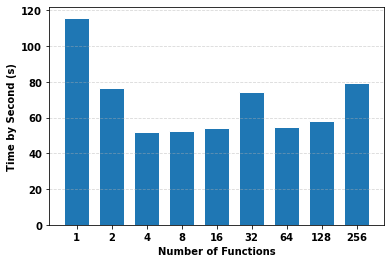

In [10]:
df2 = pd.DataFrame(processing_time)
A = list(df2['Processing_time'])

ind = np.arange(len(A))    # the x locations for the groups
width = 0.7       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, A, edgecolor='white', width=width)

plt.grid(axis='y', alpha=0.5, ls='--', zorder=0)
plt.xlabel('Number of Functions')
plt.ylabel('Time by Second (s)')
# plt.title('The processing time by using Lithops framework')
plt.xticks(ind, list(df2['Funcs_numbers']))
plt.savefig('./figures_outlier/SMRF-Processing Time at time %s.png'% (datet), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
df2['Proc_time'] = df2['Filtering_time'] + df2['Save_points']

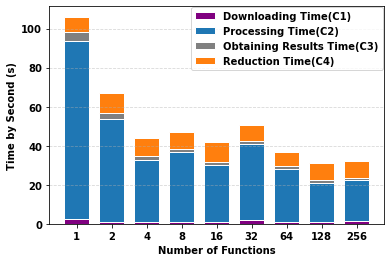

In [12]:
A = list(df2['Downloading_Time'])
B = list(df2['Proc_time'])
C = list(df2['Time_Redstart'])
D = list(df2['Reduction_time'])
# E = list(df2['Reduction_time'])

bar1 = np.add(A, B).tolist()
bar2 = np.add(A, np.add(B, C)).tolist()
# bar3 = np.add(np.add(A, B), np.add(C, D)).tolist()
ind = np.arange(len(B)) 
width = 0.7

p1 = plt.bar(ind, A, edgecolor='white', width=width, color='purple')
p2 = plt.bar(ind, B, edgecolor='white', width=width,
             bottom=A)
p3 = plt.bar(ind, C, edgecolor='white', width=width,
             bottom=bar1, color='grey')
p4 = plt.bar(ind, D, edgecolor='white', width=width,
             bottom=bar2)
# p5 = plt.bar(ind, E, edgecolor='white', width=width,
#              bottom=bar3)
plt.grid(axis='y', alpha=0.5, ls='--', zorder=0)
plt.xlabel('Number of Functions')
plt.ylabel('Time by Second (s)')
# plt.title('Approach #1: Time of Processing at a time %s'% (dt_string))
plt.xticks(ind, list(df2['Funcs_numbers']))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Downloading Time(C1)', 'Processing Time(C2)', 'Obtaining Results Time(C3)', 
                                   'Reduction Time(C4)'), loc='upper left', bbox_to_anchor=(0.41, 1.02))
plt.savefig('./figures_outlier/SMRF-Processing Time plot at time %s.png'% (datet), dpi=300, bbox_inches='tight')
plt.show()